In [157]:
import pandas as pd
import itertools
import numpy as np
from collections import defaultdict, Counter

authors_df = pd.read_csv('database/authorships.csv')
print('Unique authors:', len(authors_df['author_id'].unique()))
print('Unique works:', len(authors_df['work_id'].unique()))
print('Size of authors_df:', len(authors_df))
display(authors_df.head())

Unique authors: 10061
Unique works: 3574
Size of authors_df: 26861


,work_id,author_id,author_name,author_position,is_corresponding,countries
0,https://openalex.org/W2566403979,https://openalex.org/A5069790395,Luciana Principal Antunes,first,True,BR
1,https://openalex.org/W2566403979,https://openalex.org/A5104035388,Layla Farage Martins,middle,False,BR
2,https://openalex.org/W2566403979,https://openalex.org/A5024654137,Roberta Verciano Pereira,middle,False,BR
3,https://openalex.org/W2566403979,https://openalex.org/A5081300089,Andrew Maltez Thomas,middle,False,BR
4,https://openalex.org/W2566403979,https://openalex.org/A5026647981,Deibs Barbosa,middle,False,BR


In [158]:
works_df = pd.read_csv('database/works.csv')
print('Size of works_df:', len(works_df))
display(works_df.head())

Size of works_df: 3574


,id,title,abstract,doi,publication_date,cited_by_count,language,type,fwci,open_access,has_fulltext,is_retracted,is_paratext,locations_count,countries_distinct_count,institutions_distinct_count,referenced_works_count
0,https://openalex.org/W2566403979,Microbial community structure and dynamics in ...,NaN,https://doi.org/10.1038/srep38915,2016-12-12,258,en,article,14.351852,True,True,False,False,5,2,18,70
1,https://openalex.org/W2103764811,Genome features of Leptospira interrogans sero...,We report novel features of the genome sequenc...,https://doi.org/10.1590/s0100-879x2004000400003,2004-04-01,246,en,article,6.522597,True,True,False,False,5,2,13,67
2,https://openalex.org/W2046811660,Metagenomic Analysis of a Tropical Composting ...,Composting operations are a rich source for pr...,https://doi.org/10.1371/journal.pone.0061928,2013-04-24,147,en,article,14.455075,True,True,False,False,15,2,17,90
3,https://openalex.org/W1571611271,Brazilian bibliometric coauthorship networks,The Brazilian Lattes Platform is an important ...,https://doi.org/10.1002/asi.23010,2014-01-29,109,en,article,8.419226,True,False,False,False,3,1,4,95
4,https://openalex.org/W2972959654,Origin and diversification of Xanthomonas citr...,Abstract Background Xanthomonas citri subsp. c...,https://doi.org/10.1186/s12864-019-6007-4,2019-09-09,51,en,article,4.846846,True,True,False,False,10,2,15,104


In [159]:
merged_df = authors_df.merge(
    works_df[['id', 'publication_date']], 
    left_on='work_id', right_on='id'
)
merged_df['publication_date'] = pd.to_datetime(merged_df['publication_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['publication_date', 'author_id']).drop(columns=['id'])


print('Size of merged_df:', len(merged_df))
display(merged_df.head())

Size of merged_df: 26453


,work_id,author_id,author_name,author_position,is_corresponding,countries,publication_date
0,https://openalex.org/W2566403979,https://openalex.org/A5069790395,Luciana Principal Antunes,first,True,BR,2016-12-12
1,https://openalex.org/W2566403979,https://openalex.org/A5104035388,Layla Farage Martins,middle,False,BR,2016-12-12
2,https://openalex.org/W2566403979,https://openalex.org/A5024654137,Roberta Verciano Pereira,middle,False,BR,2016-12-12
3,https://openalex.org/W2566403979,https://openalex.org/A5081300089,Andrew Maltez Thomas,middle,False,BR,2016-12-12
4,https://openalex.org/W2566403979,https://openalex.org/A5026647981,Deibs Barbosa,middle,False,BR,2016-12-12


In [160]:
unique_works = merged_df[['work_id', 'publication_date']].drop_duplicates().sort_values('publication_date')
split_idx = int(len(unique_works) * 0.8)

train_work_ids = set(unique_works.iloc[:split_idx]['work_id'])
test_work_ids = set(unique_works.iloc[split_idx:]['work_id'])

train_df = merged_df[merged_df['work_id'].isin(train_work_ids)]
test_df = merged_df[merged_df['work_id'].isin(test_work_ids)]

print('Size of unique_works:', len(unique_works))
print('Train work ids:', len(train_work_ids))
print('Test work ids:', len(test_work_ids))
display(train_df.head())


Size of unique_works: 3574
Train work ids: 2859
Test work ids: 715


,work_id,author_id,author_name,author_position,is_corresponding,countries,publication_date
0,https://openalex.org/W2566403979,https://openalex.org/A5069790395,Luciana Principal Antunes,first,True,BR,2016-12-12
1,https://openalex.org/W2566403979,https://openalex.org/A5104035388,Layla Farage Martins,middle,False,BR,2016-12-12
2,https://openalex.org/W2566403979,https://openalex.org/A5024654137,Roberta Verciano Pereira,middle,False,BR,2016-12-12
3,https://openalex.org/W2566403979,https://openalex.org/A5081300089,Andrew Maltez Thomas,middle,False,BR,2016-12-12
4,https://openalex.org/W2566403979,https://openalex.org/A5026647981,Deibs Barbosa,middle,False,BR,2016-12-12


In [161]:
def build_graph(df):
    graph = defaultdict(set)
    for _, group in df.groupby('work_id'):
        authors = group['author_id'].tolist()
        
        if len(authors) > 1:
            for u, v in itertools.permutations(authors, 2):
                graph[u].add(v)

    return graph

train_graph = build_graph(train_df)
print("Number of Authors in Train Graph:", len(train_graph))
print(f"Mean of coauthors per author: {np.mean([len(v) for v in train_graph.values()]):.2f}")

test_graph_raw = build_graph(test_df)
print("Number of Authors in Test Graph:", len(test_graph_raw))
print(f"Mean of coauthors per author: {np.mean([len(v) for v in test_graph_raw.values()]):.2f}")

Number of Authors in Train Graph: 7805
Mean of coauthors per author: 27.57
Number of Authors in Test Graph: 3054
Mean of coauthors per author: 24.67


In [162]:
test_ground_truth = defaultdict(set)

for author, coauthors in test_graph_raw.items():
    # Pega quem o autor colaborou no futuro
    future_coauthors = coauthors
    
    # Remove quem ele JÁ conhecia no passado (não é predição nova)
    past_coauthors = train_graph.get(author, set())
    new_links = future_coauthors - past_coauthors
    
    if new_links:
        test_ground_truth[author] = new_links
        
print(f"Authors in Train Graph: {len(train_graph)}")
print(f"Authors with new connections in Test Graph: {len(test_ground_truth)}")

Authors in Train Graph: 7805
Authors with new connections in Test Graph: 2913


In [163]:
popularity_counter = Counter()
for author, neighbors in train_graph.items():
    popularity_counter[author] = len(neighbors)

display(popularity_counter)

most_popular_authors = [auth for auth, count in popularity_counter.most_common()]

Counter({'https://openalex.org/A5060418877': 1351,
         'https://openalex.org/A5057185934': 1299,
         'https://openalex.org/A5006714133': 1014,
         'https://openalex.org/A5066066519': 823,
         'https://openalex.org/A5033650450': 765,
         'https://openalex.org/A5050012549': 686,
         'https://openalex.org/A5073516344': 593,
         'https://openalex.org/A5100336484': 569,
         'https://openalex.org/A5064279441': 561,
         'https://openalex.org/A5046142910': 504,
         'https://openalex.org/A5041592879': 467,
         'https://openalex.org/A5053911927': 463,
         'https://openalex.org/A5030562453': 452,
         'https://openalex.org/A5070322730': 426,
         'https://openalex.org/A5108713413': 419,
         'https://openalex.org/A5079483159': 402,
         'https://openalex.org/A5026777870': 385,
         'https://openalex.org/A5087783258': 378,
         'https://openalex.org/A5080238381': 357,
         'https://openalex.org/A5063874155': 33

In [164]:
def recommend_coauthors(author_id, graph, top_n=10):
    recommendations = []

    if author_id in graph:
        current_coauthors = graph[author_id]
        candidates = []

        for neighbor in current_coauthors:
            neighbors_of_neighbor = graph.get(neighbor, set())
            for candidate in neighbors_of_neighbor:
                if candidate != author_id and candidate not in current_coauthors:
                    candidates.append(candidate)

        # Pega os melhores baseados em vizinhos em comum
        recommendations = [c[0] for c in Counter(candidates).most_common(top_n)]
    else:
        # Caso Cold Start: Se o autor não está no grafo, current_coauthors é vazio
        current_coauthors = set()

    if len(recommendations) < top_n:
        for pop_author in most_popular_authors:
            if (pop_author != author_id and 
                pop_author not in recommendations and 
                pop_author not in current_coauthors):
                
                recommendations.append(pop_author)
                
                if len(recommendations) >= top_n:
                    break
                    
    return recommendations


author_id_sample = train_df.sample(1, random_state=42).iloc[0]["author_id"]
recommendations = recommend_coauthors(author_id_sample, train_graph, top_n=10)

current_coauthors = train_graph[author_id_sample]

print("Author:", author_id_sample)
display("Recommendations:", recommendations)

Author: https://openalex.org/A5052753948


'Recommendations:'

['https://openalex.org/A5059183159',
 'https://openalex.org/A5069217530',
 'https://openalex.org/A5042672512',
 'https://openalex.org/A5046932014',
 'https://openalex.org/A5080529521',
 'https://openalex.org/A5108713413',
 'https://openalex.org/A5057994483',
 'https://openalex.org/A5049557058',
 'https://openalex.org/A5070322730',
 'https://openalex.org/A5035048985']

In [166]:
K = 5
precisions = []
recalls = []

# Avaliamos APENAS autores que realmente formaram novas conexões
# (Não faz sentido avaliar quem parou de publicar ou só trabalhou com velhos amigos)
for author_id, actual_new_coauthors in test_ground_truth.items():

    recommendations = recommend_coauthors(author_id, train_graph, top_n=K)

    hits = len(set(recommendations) & actual_new_coauthors)

    # Precision: Dos que eu recomendei, quantos eram verdadeiros?
    p = hits / len(recommendations)

    # Recall: Dos que existiam de verdade, quantos eu encontrei?
    r = hits / len(actual_new_coauthors)

    precisions.append(p)
    recalls.append(r)

avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)

if (avg_precision + avg_recall) > 0:
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
else:
    f1_score = 0

print("-" * 40)
print(f"Resultados da Avaliação (Top-{K}):")
print(f"Precision: {avg_precision:.4f} {avg_precision*100:.1f}%")
print(f"Recall:    {avg_recall:.4f} {avg_recall*100:.1f}%")
print(f"F1-Score:  {f1_score:.4f} {f1_score*100:.1f}%")
print("-" * 40)

----------------------------------------
Resultados da Avaliação (Top-5):
Precision: 0.0571 5.7%
Recall:    0.0269 2.7%
F1-Score:  0.0366 3.7%
----------------------------------------


K=5: Precision=0.0571 (5.7%), Recall=0.0269 (2.7%), F1-Score=0.0366 (3.7%)
K=10: Precision=0.0491 (4.9%), Recall=0.0510 (5.1%), F1-Score=0.0501 (5.0%)
K=20: Precision=0.0310 (3.1%), Recall=0.0668 (6.7%), F1-Score=0.0423 (4.2%)


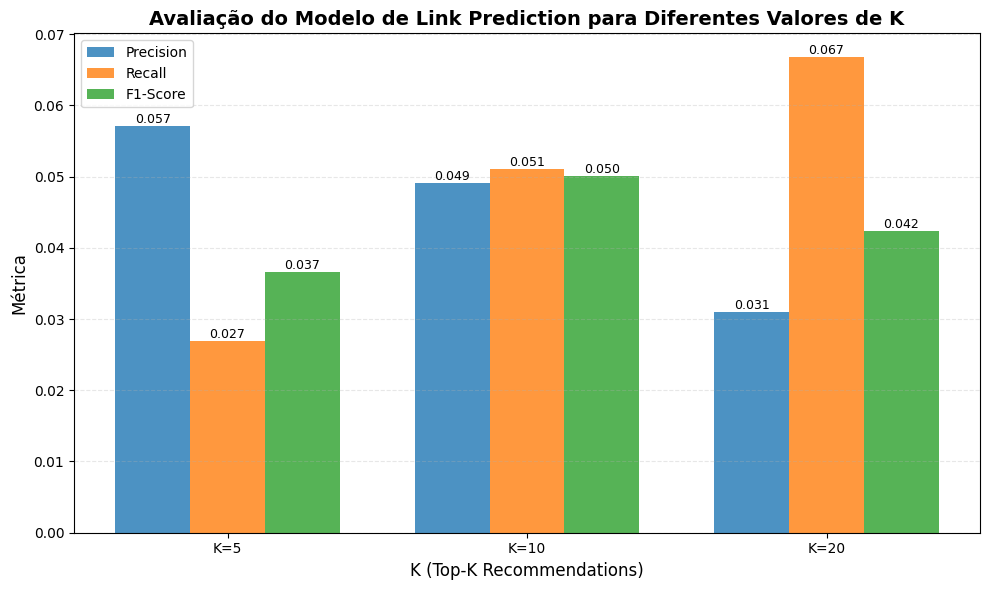


RESUMO DAS MÉTRICAS
K     Precision    Recall       F1-Score    
------------------------------------------------------------
5     0.0571       0.0269       0.0366      
10    0.0491       0.0510       0.0501      
20    0.0310       0.0668       0.0423      


In [ ]:
import matplotlib.pyplot as plt

K_values = [5, 10, 20]
results = {}

for K in K_values:
    precisions = []
    recalls = []
    
    # Avaliamos APENAS autores que realmente formaram novas conexões
    for author_id, actual_new_coauthors in test_ground_truth.items():
        recommendations = recommend_coauthors(author_id, train_graph, top_n=K)
        
        hits = len(set(recommendations) & actual_new_coauthors)
        
        # Precision: Dos que eu recomendei, quantos eram verdadeiros?
        p = hits / len(recommendations) if len(recommendations) > 0 else 0
        
        # Recall: Dos que existiam de verdade, quantos eu encontrei?
        r = hits / len(actual_new_coauthors) if len(actual_new_coauthors) > 0 else 0
        
        precisions.append(p)
        recalls.append(r)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    if (avg_precision + avg_recall) > 0:
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    else:
        f1_score = 0
    
    results[K] = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': f1_score
    }
    
    print(f"K={K}: Precision={avg_precision:.4f} ({avg_precision*100:.1f}%), "
          f"Recall={avg_recall:.4f} ({avg_recall*100:.1f}%), "
          f"F1-Score={f1_score:.4f} ({f1_score*100:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 6))

k_list = list(results.keys())
precision_values = [results[k]['precision'] for k in k_list]
recall_values = [results[k]['recall'] for k in k_list]
f1_values = [results[k]['f1_score'] for k in k_list]

x = np.arange(len(k_list))
width = 0.25

bars1 = ax.bar(x - width, precision_values, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_values, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_values, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('K (Top-K Recommendations)', fontsize=12)
ax.set_ylabel('Métrica', fontsize=12)
ax.set_title('Avaliação do Modelo de Link Prediction para Diferentes Valores de K', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'K={k}' for k in k_list])
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RESUMO DAS MÉTRICAS")
print("="*60)
print(f"{'K':<5} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)
for K in K_values:
    print(f"{K:<5} {results[K]['precision']:<12.4f} {results[K]['recall']:<12.4f} {results[K]['f1_score']:<12.4f}")
print("="*60)
